In [1]:
import numpy as np
import pandas as pd
from capture_image import capture_image
import sys
import os
import warnings
import numpy as np
import rtde_control
import rtde_receive
from rtde_control import Path, PathEntry
import rtde_io
from robotiq_gripper_control import RobotiqGripper
import time
import numpy as np
import rotation_matrix as rm
import pandas as pd

# add parent folder to sys.path
sys.path.insert(0, os.path.abspath(".."))

# ignore DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ignore RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

from volume_estimation.src.models_1_no_vol.predict_full_pipeline import predict_no_vol
from segmentation_and_depth.src.models.predict_model import predict as predict_seg_depth
from volume_estimation.src.models_2_input_vol.predict_full_pipeline import (
    predict_with_vol,
)

In [2]:
def connect_robot(ip="192.168.2.1"):
    rtde_c = rtde_control.RTDEControlInterface(ip)  # IP address found on robot
    rtde_r = rtde_receive.RTDEReceiveInterface(ip)
    rtde_io_set = rtde_io.RTDEIOInterface(ip)
    return rtde_c, rtde_r, rtde_io_set


rtde_c, rtde_r, rtde_io_set = connect_robot()

print("Activating Gripper")
gripper = RobotiqGripper(rtde_c)
gripper.activate()  # returns to previous position after activation
gripper.set_force(10)  # from 0 to 100 %
gripper.set_speed(10)  # from 0 to 100 %
print("Gripper activated")
gripper.move(45)

Activating Gripper
Gripper activated


True

In [3]:
pick_up_pos_1 = [
    -0.20933143110289607,
    0.4007959363962377,
    0.14113332170567885,
    -1.559202807626822,
    0.03734946834843037,
    0.004841554724431051,
]

pick_up_pos_2 = [
    -0.23954717580833165,
    0.400795552537626,
    0.07130884774090128,
    -1.5591976930082265,
    0.037387010510812266,
    0.004880320202878557,
]

j_pick_up_2 = [
    -3.249948565159933,
    -1.9834510288634242,
    -2.529017448425293,
    4.618844195003174,
    -0.07713920274843389,
    -3.2202377955066126,
]

pick_up_pos_4 = [
    -0.23473853377504333,
    0.47152953670488773,
    0.053494416798714306,
    -1.5710858755788153,
    0.017660070482072698,
    0.01776629011841677,
]  # gripping_pos

move_to_pouring_pos_1 = [
    -0.23473853377504333,
    0.47152953670488773,
    0.183494416798714306,
    -1.5710858755788153,
    0.017660070482072698,
    0.01776629011841677,
]

move_to_pouring_pos_2 = [
    -0.22901634283841804,
    0.41998903523904,
    0.2949162372788959,
    -1.5751694238784661,
    -0.21652305912711,
    0.25229985538985844,
]

move_to_pouring_pos_3 = [
    -0.3979018097425171,
    0.1980390973153733,
    0.28823304066468763,
    -1.3004855590335682,
    -1.1848976095494719,
    1.213794766836109,
]

start_pos_horizontal = [
    -0.36498883237255164,
    0.24715099595577825 + 0.003,
    0.17519255890890678,
    -1.221741554832158,
    -1.213214812915213,
    1.2457124592502689,
]

start_pos_bottle_rotated = [
    -0.36498143802471317,
    0.2501417037919356,
    0.17515693872394192,
    -1.4078543077400933,
    -1.0821978511944732,
    1.4284556202410212,
]

picture_pos_1 = [
    -0.2508972778772122,
    0.31703212756890126,
    0.040906871156296015,
    -1.7529907634479511,
    0.12417168282165422,
    -0.061325016996647067,
]

j_camera_1 = [
    -2.9296885172473353,
    -1.939632078210348,
    -2.58204984664917,
    5.015304672508993,
    0.4201672077178955,
    -3.563404146824972,
]

j_camera_2 = [
    -2.8262293974505823,
    -1.7413660488524378,
    -2.765547037124634,
    5.107378023653784,
    0.4118742346763611,
    -3.680626932774679,
]

picture_pos_2 = [
    -0.18388204797500857,
    0.34816752489991387,
    0.05156358055378852,
    -1.8605080000953258,
    -0.22422002634041718,
    0.2288772579694372,
]

j_regrip_bottle = [
    -4.042497936879293,
    -1.7331849537291468,
    -1.2813172340393066,
    4.603957338924072,
    1.570102334022522,
    -4.015312496815817,
]
j_change_grip = [
    -3.413373057042257,
    -1.4406905335238953,
    -2.222731828689575,
    3.6686197954365234,
    -0.24977237382997686,
    -3.1186557451831263,
]

# Decapper
j_below_decap = [
    -3.65891677538027,
    -1.9373651943602503,
    -1.688409447669983,
    3.641084833736084,
    -0.49509984651674444,
    -3.6422672907458704,
]

# Pouring Bottle
j_mid_pouring = [
    -3.4139297644244593,
    -1.0136956733516236,
    -2.2226736545562744,
    3.252027674312256,
    -0.2501028219806116,
    -3.118774477635519,
]
j_pouring = [
    -3.6846988836871546,
    -1.1872257751277466,
    -2.1598119735717773,
    3.354879541988037,
    -2.109131638203756,
    -3.0650396982776087,
]

In [4]:
rtde_c.moveJ(j_change_grip, 0.1, 0.1)

True

In [4]:
def pour_bottle(
    stop_angle, stop_time, rtde_c, vel_L=0.0074, acc_L=1.5, blending=0.0015
):
    start_pos_horizontal = [
        -0.36498883237255164,
        0.24715099595577825 + 0.003,
        0.17519255890890678,
        -1.221741554832158,
        -1.213214812915213,
        1.2457124592502689,
    ]
    start_pos_bottle_rotated = [
        -0.36498143802471317,
        0.2501417037919356,
        0.17515693872394192,
        -1.4078543077400933,
        -1.0821978511944732,
        1.4284556202410212,
    ]

    # find TCP path
    stop_angle = int(stop_angle)
    stop_time = int(stop_time)

    to_find = "_" + str(stop_angle) + "_" + str(stop_time)

    # iterate through all folders in folder_path
    folder_path = r"../pouring_simulation/output/MediaBottle_diff"

    # iterate through all folders in folder_path
    for filename in os.listdir(folder_path):
        # if folder contains to_find
        if to_find in filename:
            scene_path = os.path.join(folder_path, filename)
            # Count the total number of rows in the file
            with open(scene_path, "r") as file:
                num_rows = sum(1 for _ in file)
            # load datapoints and skip first and last 5
            data_points = np.loadtxt(
                scene_path, delimiter=",", skiprows=1, max_rows=num_rows - 2
            )
            print("Scene path: ", scene_path)
            print(data_points.shape)
            break

    # convert from inches to meters
    data_points[:, 0] = data_points[:, 0] * 0.0254
    data_points[:, 1] = data_points[:, 1] * 0.0254
    data_points[:, 2] = data_points[:, 2] + 0.25307274

    # create list of positions
    positions = []
    for i in range(data_points.shape[0]):
        positions.append(
            [data_points[i, 0], -data_points[i, 1], 0.0, 0.0, 0.0, data_points[i, 2]]
        )  # will move around x, y of tool and rotate around z of tool --> to be updated for different setups

    positions_converted = []
    for i in range(data_points.shape[0]):
        # if none of the data entries is 0
        if not (positions[i][0] == 0 or positions[i][1] == 0 or positions[i][5] == 0):
            positions_converted.append(
                rm.PoseTrans(start_pos_horizontal, positions[i])
            )  # transform from tool coordinate system to base coordinate system

    # get position of the first duplicate converted_position that is not position 0
    for i in range(len(positions_converted)):
        if positions_converted[i] == positions_converted[0]:
            continue
        elif (
            positions_converted[i]
            == positions_converted[i - 1]
            == positions_converted[i - 2]
            == positions_converted[i - 3]
            == positions_converted[i - 4]
        ):
            print(i)
            break

    # count the values that are the same as i
    count = 0
    for j in range(i, len(positions_converted)):
        if positions_converted[j] == positions_converted[i]:
            count += 1
        else:
            break

    # split positions_converted into two lists
    positions_converted1 = positions_converted[0:i]
    positions_converted2 = positions_converted[i:]

    rtde_c.moveL(start_pos_bottle_rotated, 0.1, 0.1)

    blend_i = blending
    path = []
    for i in range(len(positions_converted1) - 1):
        path.append(
            [
                positions_converted1[i][0],
                positions_converted1[i][1],
                positions_converted1[i][2],
                positions_converted1[i][3],
                positions_converted1[i][4],
                positions_converted1[i][5],
                vel_L,
                acc_L,
                blend_i,
            ]
        )

    path.append(
        [
            positions_converted1[-1][0],
            positions_converted1[-1][1],
            positions_converted1[-1][2],
            positions_converted1[-1][3],
            positions_converted1[-1][4],
            positions_converted1[-1][5],
            vel_L,
            acc_L,
            0,
        ]
    )
    rtde_c.moveL(path)

    time.sleep(count / 150)

    path_2 = []
    for i in range(len(positions_converted2) - 1):
        path_2.append(
            [
                positions_converted2[i][0],
                positions_converted2[i][1],
                positions_converted2[i][2],
                positions_converted2[i][3],
                positions_converted2[i][4],
                positions_converted2[i][5],
                vel_L,
                acc_L,
                blend_i,
            ]
        )

    path_2.append(
        [
            positions_converted2[-1][0],
            positions_converted2[-1][1],
            positions_converted2[-1][2],
            positions_converted2[-1][3],
            positions_converted2[-1][4],
            positions_converted2[-1][5],
            vel_L,
            acc_L,
            0,
        ]
    )
    rtde_c.moveL(path_2)

In [5]:
def move_to_pick_up(rtde_c, gripper):
    gripper.open()
    rtde_c.moveJ(j_pick_up_2, 0.1, 0.1)
    rtde_c.moveL(pick_up_pos_4, 0.1, 0.1)


def estimate_volume(rtde_c):
    rtde_c.moveJ(j_pick_up_2, 0.3, 0.3)
    rtde_c.moveJ(j_camera_1, 0.3, 0.3)
    path = capture_image()
    pred_vol_1 = predict_with_vol(
        path,
        save_segmentation=False,
        save_depth=False,
        predict_volume=True,
        vessel_volume=755,
        no_GPU=True,
    )

    rtde_c.moveJ(j_camera_2, 0.3, 0.3)
    path = capture_image()
    pred_vol_2 = predict_with_vol(
        path,
        save_segmentation=False,
        save_depth=False,
        predict_volume=True,
        vessel_volume=755,
        no_GPU=True,
    )

    input_start_vol = (pred_vol_1 + pred_vol_2) / 2

    return input_start_vol


def find_best_parameters(input_start_vol, input_target_vol):
    input_target_vol -= 10  # correction factor
    summary_flask = pd.read_csv(
        "../pouring_simulation/output/summary_medium_final.csv", skiprows=[0, 1]
    )
    min_loss = 100000

    for j in range(len(summary_flask)):
        loss = abs(summary_flask.iloc[j, 5] - input_start_vol) + abs(
            summary_flask.iloc[j, 7] - input_target_vol
        )  # + summary_flask.iloc[j,8]*0.3
        if loss < min_loss:
            min_loss = loss
            stop_angle = summary_flask.iloc[j, 3]
            stop_time = (summary_flask.iloc[j, 4]) * 1000

    return stop_angle, stop_time


def get_bottle(rtde_c, gripper):
    rtde_c.moveJ(j_pick_up_2, 0.3, 0.3)
    gripper.open()
    rtde_c.moveL(pick_up_pos_4, 0.3, 0.3)
    gripper.close()
    rtde_c.moveL(move_to_pouring_pos_1, 0.3, 0.3)
    rtde_c.moveL(move_to_pouring_pos_2, 0.3, 0.3)
    rtde_c.moveL(move_to_pouring_pos_3, 0.3, 0.3)
    rtde_c.moveL(start_pos_bottle_rotated, 0.3, 0.3)


def place_back(rtde_c, gripper):
    rtde_c.moveL(start_pos_bottle_rotated, 0.3, 0.3)
    rtde_c.moveL(move_to_pouring_pos_3, 0.3, 0.3)
    rtde_c.moveL(move_to_pouring_pos_2, 0.3, 0.3)
    rtde_c.moveL(move_to_pouring_pos_1, 0.3, 0.3)
    rtde_c.moveL(pick_up_pos_4, 0.3, 0.3)
    gripper.open()
    rtde_c.moveL(pick_up_pos_2, 0.3, 0.3)

In [6]:
def autonomous_pouring(rtde_c, gripper, target_vol):
    input_start_vol = estimate_volume(rtde_c)
    stop_angle, stop_time = find_best_parameters(input_start_vol, target_vol)
    get_bottle(rtde_c, gripper)
    pour_bottle(stop_angle, stop_time, rtde_c)
    place_back(rtde_c, gripper)

In [7]:
pos = rtde_r.getActualTCPPose()
pos

[-0.3649757287404091,
 0.2501452824488981,
 0.1751423689288486,
 -1.4079201148603206,
 -1.0821989616094552,
 1.4284477652621526]

In [10]:
pos_j = rtde_r.getActualQ()
pos_j

[-2.8262293974505823,
 -1.7413660488524378,
 -2.765547037124634,
 5.107378023653784,
 0.4118742346763611,
 -3.680626932774679]

In [8]:
rtde_c.moveL(pick_up_pos_2, 0.1, 0.1)

True

In [9]:
rtde_c.moveJ(j_camera_1, 0.1, 0.1)

True

### Process to try:

In [8]:
move_to_pick_up(rtde_c=rtde_c, gripper=gripper)  # move to start position

Image saved
Predicted liquid volume: 96 mL


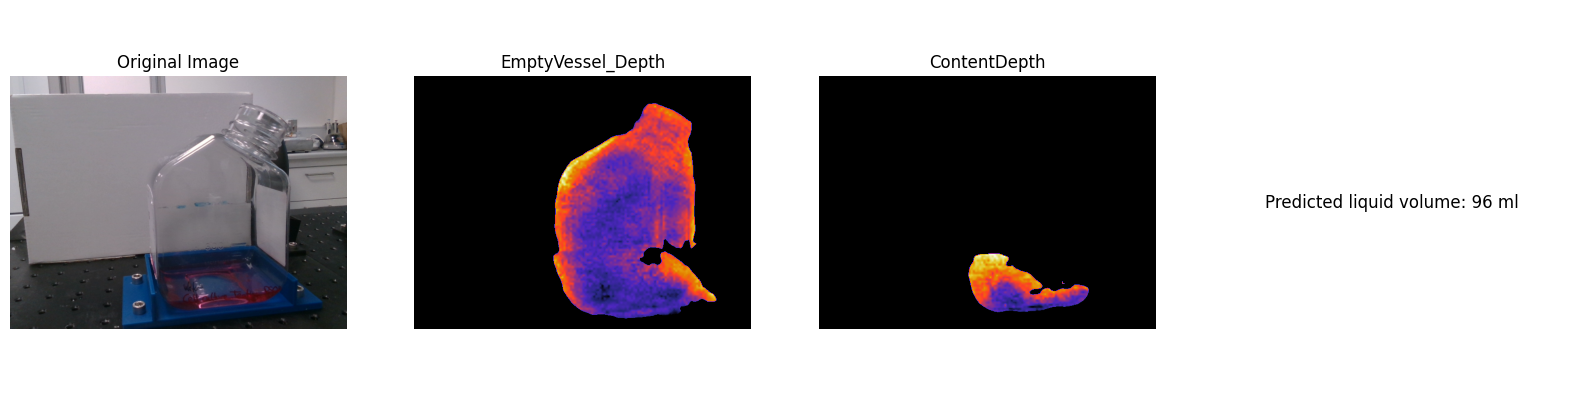

Image saved
Predicted liquid volume: 104 mL


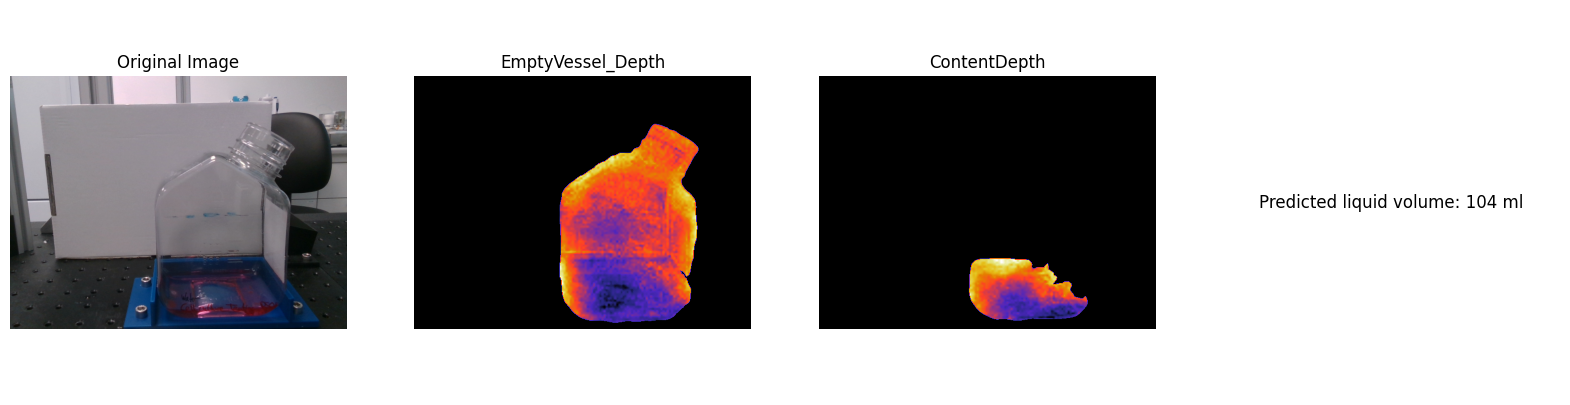

Scene path:  ../pouring_simulation/output/MediaBottle_diff\TCP_84_200.txt
(5931, 3)
2933


In [13]:
autonomous_pouring(rtde_c=rtde_c, gripper=gripper, target_vol=50)